# Projeto Final — Aprendizado de Máquina  
## Parte 1: Análise Exploratória de Dados (EDA)  
### Tema: Obesidade (Our World in Data)

---

## 1. Introdução e Objetivo do Projeto

A obesidade é considerada um dos principais problemas de saúde pública no século XXI, associada a doenças crônicas (como diabetes tipo 2, hipertensão e doenças cardiovasculares) e a impactos econômicos significativos.  

O objetivo deste projeto é analisar dados globais sobre obesidade, buscando compreender suas tendências ao longo do tempo, diferenças entre países e possíveis fatores associados.  

As principais perguntas que orientam esta investigação são:  
1. Como a obesidade evoluiu ao longo do tempo em escala global?  
2. Existem diferenças relevantes entre homens e mulheres?  
3. Quais regiões do mundo apresentam maiores taxas?  
4. Quais países se destacam com as maiores e menores prevalências?  
5. O nível de renda influencia na prevalência de obesidade?  
6. Quais países tiveram os maiores crescimentos ao longo das últimas décadas?  
7. Existe correlação entre obesidade e fatores socioeconômicos (como PIB per capita)?  
8. A obesidade varia entre diferentes faixas etárias?  

---


In [15]:
# ================================================================
# Bibliotecas principais
# ================================================================
import pandas as pd
import matplotlib.pyplot as plt

# Configurações globais de visualização
plt.rcParams["figure.figsize"] = (10,5)
plt.style.use("default")


## 2. Descrição da Base de Dados

- **Fonte:** [Our World in Data — Obesity](https://ourworldindata.org/obesity-definition)  
- **Unidade de análise:** cada linha representa a prevalência de obesidade/sobrepeso em um país, em um determinado ano.  
- **Datasets utilizados:**
  1. **Adultos (18+ anos):** prevalência de obesidade (BMI ≥ 30).  
  2. **Crianças menores de 5 anos:** prevalência de sobrepeso (% acima do peso para altura).  
  3. **Crianças e adolescentes (5–19 anos):** prevalência de sobrepeso (BMI > +1 desvio padrão da mediana).  

- **Principais atributos (colunas após unificação):**
  - `Entity`: nome do país ou região.  
  - `Code`: código ISO do país.  
  - `Year`: ano da observação.  
  - `Adults_Obesity`: prevalência de obesidade em adultos (%).  
  - `Children_Overweight`: prevalência de sobrepeso em crianças <5 anos (%).  
  - `ChildAdol_Overweight`: prevalência de sobrepeso em crianças/adolescentes 5–19 anos (%).  
  


In [33]:
# ================================================================
# Bibliotecas principais
# ================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

# Configurações globais de visualização
plt.rcParams["figure.figsize"] = (12, 7)
plt.style.use("default")

# Caminhos de todos os arquivos
file_adults = "share-of-adults-defined-as-obese.csv"
file_children = "children-who-are-overweight-sdgs.csv"
file_child_adol = "child-adolescent-obesity.csv"
file_gdp = "gdp-per-capita-worldbank.csv"

# ================================================================
# 2. Carregamento e Unificação dos Dados
# ================================================================

try:
    # --- ETAPA 1: Carregar e Renomear DataFrames ---

    # Carregar datasets de obesidade e renomear colunas longas
    df_adults = pd.read_csv(file_adults).rename(columns={
        "Prevalence of obesity among adults, BMI >= 30 (crude estimate) (%) - Sex: both sexes - Age group: 18+  years of age": "Adults_Obesity"
    })

    df_children = pd.read_csv(file_children).rename(columns={
        "Overweight prevalence among children under 5 years of age (% weight-for-height >+2 SD), model-based estimates - Sex: both sexes": "Children_Overweight"
    })

    df_child_adol = pd.read_csv(file_child_adol).rename(columns={
        "Prevalence of overweight among children and adolescents, BMI > +1 standard deviations above the median (crude estimate) (%) - Sex: both sexes - Age group: 5-19  years of age": "ChildAdol_Overweight"
    })

    # Carregar e Renomear dataset de PIB (Correção Robusta do Erro de Coluna)
    df_gdp_original = pd.read_csv(file_gdp)
    
    # Identifica a única coluna de valor no arquivo GDP (que tem o nome longo)
    # Incluído 'World regions according to OWID' na lista de ignorados
    columns_to_ignore = ["Entity", "Code", "Year", "World regions according to OWID"]
    value_column_list = [col for col in df_gdp_original.columns if col not in columns_to_ignore]
    
    # Garante que a coluna de valor foi encontrada e a renomeia
    if not value_column_list:
        raise KeyError("Não foi possível identificar a coluna de valor no arquivo GDP.")
        
    value_column = value_column_list[0]

    df_gdp = df_gdp_original.rename(columns={
        value_column: "GDP per capita"
    })

    # --- ETAPA 2: Unificar os dados ---

    # Unificar os três datasets de obesidade (usando 'outer' para manter todos os dados)
    df_merged_all = df_adults.merge(df_children, on=["Entity", "Code", "Year"], how="outer")
    df_merged_all = df_merged_all.merge(df_child_adol, on=["Entity", "Code", "Year"], how="outer")

    # Unificar com o DataFrame de PIB (usando 'left' para manter todas as linhas de obesidade)
    df_final = df_merged_all.merge(df_gdp[["Entity", "Year", "GDP per capita"]], on=["Entity", "Year"], how="left")
    
    # Renomear 'Entity' para 'Country' para clareza
    df_final = df_final.rename(columns={'Entity': 'Country'})
    
    # Definindo a variável principal 'df'
    df = df_final.copy()


    # --- ETAPA 3: Conferir o resultado final ---
    print("Dados carregados e unificados com sucesso!")
    print(f"Shape do DataFrame final: {df.shape}")
    print("\nVisualização das primeiras linhas:")
    print(df.head())
    print("\nInformações sobre as colunas (incluindo contagem de não-nulos):")
    df.info()

except Exception as e:
    print(f"Ocorreu um erro durante o carregamento/unificação dos dados: {e}")

Dados carregados e unificados com sucesso!
Shape do DataFrame final: (8141, 7)

Visualização das primeiras linhas:
       Country Code  Year  Adults_Obesity  Children_Overweight  \
0  Afghanistan  AFG  1990         1.68080                  NaN   
1  Afghanistan  AFG  1991         1.81298                  NaN   
2  Afghanistan  AFG  1992         1.95725                  NaN   
3  Afghanistan  AFG  1993         2.11433                  NaN   
4  Afghanistan  AFG  1994         2.28502                  NaN   

   ChildAdol_Overweight  GDP per capita  
0               3.10223             NaN  
1               3.26977             NaN  
2               3.45024             NaN  
3               3.64325             NaN  
4               3.85225             NaN  

Informações sobre as colunas (incluindo contagem de não-nulos):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8141 entries, 0 to 8140
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------   

## 3. Preparação da Base de Dados

- Padronização de nomes de colunas.  
- Remoção de valores nulos em `obesity_rate`.  
- Ajuste de tipos de variáveis.  
- Eliminação de duplicatas.  


In [32]:
# --- Start of the corrected block ---

# Assign the merged dataframe to 'df' to work with it
df = df_merged_all

# Informações gerais
df.info()

# Estatísticas descritivas
df.describe()

# Verificação de valores faltantes
df.isna().sum()

# Renomear colunas (ajuste conforme necessário)
# Note: 'Prevalence of obesity...' was already renamed, so we just rename the others.
df = df.rename(columns={
    "Entity": "country",
    "Code": "code",
    "Year": "year"
})

# Remover valores nulos na coluna de obesidade de adultos
# The column is now "Adults_Obesity", not "obesity_rate"
df = df.dropna(subset=["Adults_Obesity"])

# Remover duplicatas
df = df.drop_duplicates()

## 3. Análise e Estratégia de Tratamento de Dados Ausentes (NaN)

print("Percentual de NaN por Coluna:")
# Calcula a porcentagem de valores nulos em cada coluna
print((df.isnull().sum() / len(df)) * 100)

# Display the first few rows to confirm changes
df.head()

# --- End of the corrected block ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8141 entries, 0 to 8140
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entity                8141 non-null   object 
 1   Code                  6951 non-null   object 
 2   Year                  8141 non-null   int64  
 3   Adults_Obesity        6798 non-null   float64
 4   Children_Overweight   5300 non-null   float64
 5   ChildAdol_Overweight  6798 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 381.7+ KB
Percentual de NaN por Coluna:
country                  0.000000
code                     2.912621
year                     0.000000
Adults_Obesity           0.000000
Children_Overweight     41.791703
ChildAdol_Overweight     0.000000
dtype: float64


,country,code,year,Adults_Obesity,Children_Overweight,ChildAdol_Overweight
0,Afghanistan,AFG,1990,1.68080,NaN,3.10223
1,Afghanistan,AFG,1991,1.81298,NaN,3.26977
2,Afghanistan,AFG,1992,1.95725,NaN,3.45024
3,Afghanistan,AFG,1993,2.11433,NaN,3.64325
4,Afghanistan,AFG,1994,2.28502,NaN,3.85225


## 4. Análise Exploratória de Dados (EDA)

Nesta seção vamos explorar as três faixas etárias disponíveis:
- **Adultos (18+ anos)**  
- **Crianças <5 anos**  
- **Crianças e adolescentes (5–19 anos)**  

O objetivo é identificar padrões globais e por países.



### 4.1 Evolução global das três faixas etárias


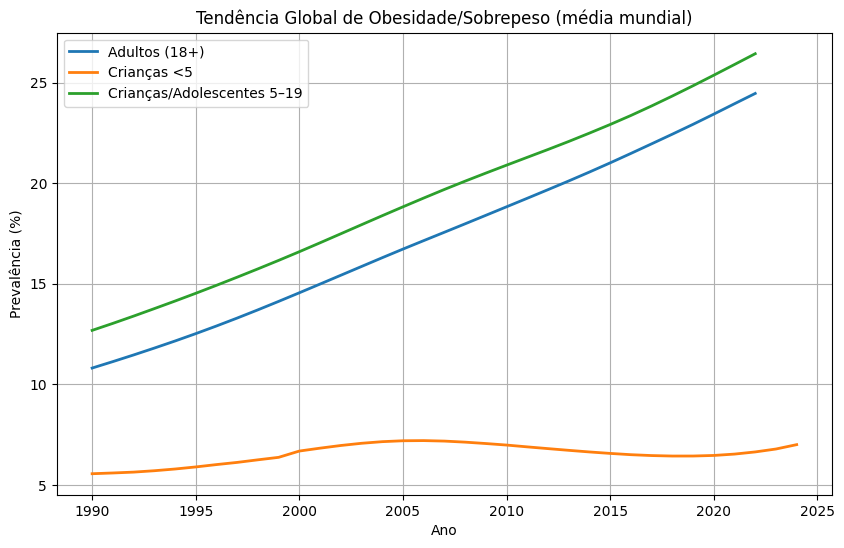

In [18]:
# Média mundial por ano
global_trend = df_merged_all.groupby("Year")[["Adults_Obesity", "Children_Overweight", "ChildAdol_Overweight"]].mean()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
for col, label in zip(global_trend.columns, ["Adultos (18+)", "Crianças <5", "Crianças/Adolescentes 5–19"]):
    plt.plot(global_trend.index, global_trend[col], label=label, linewidth=2)

plt.title("Tendência Global de Obesidade/Sobrepeso (média mundial)")
plt.xlabel("Ano")
plt.ylabel("Prevalência (%)")
plt.legend()
plt.grid(True)
plt.show()


### 4.2 Países com maiores e menores prevalências (ano mais recente)


In [39]:
# 1. Preparação dos Dados: Obtendo o dado mais recente para cada país
df_latest_data = df.sort_values(by='Year', ascending=False).drop_duplicates(subset=['Country'])
max_year_in_snapshot = df_latest_data['Year'].max()


print(f"## 4.2 Países com maiores e menores prevalências (Dados mais recentes)")
print(f"--- Dados entre 1990 e {max_year_in_snapshot} ---\n")

# --- Obesidade em Adultos ---
df_adults = df_latest_data.dropna(subset=['Adults_Obesity'])

# Top 10
top_10_adults = df_adults.nlargest(10, 'Adults_Obesity')[['Country', 'Adults_Obesity', 'Year']]
print("Top 10 Países - Obesidade em Adultos (%):")
print(top_10_adults.to_string(index=False, float_format="{:.2f}".format)) # CORREÇÃO AQUI

# Bottom 10
bottom_10_adults = df_adults.nsmallest(10, 'Adults_Obesity')[['Country', 'Adults_Obesity', 'Year']]
print("\nBottom 10 Países - Obesidade em Adultos (%):")
print(bottom_10_adults.to_string(index=False, float_format="{:.2f}".format)) # CORREÇÃO AQUI


# --- Sobrepeso em Crianças/Adolescentes ---
df_child_adol = df_latest_data.dropna(subset=['ChildAdol_Overweight'])

# Top 10
top_10_child_adol = df_child_adol.nlargest(10, 'ChildAdol_Overweight')[['Country', 'ChildAdol_Overweight', 'Year']]
print("\nTop 10 Países - Sobrepeso em Crianças/Adolescentes (%):")
print(top_10_child_adol.to_string(index=False, float_format="{:.2f}".format)) # CORREÇÃO AQUI

# Bottom 10
bottom_10_child_adol = df_child_adol.nsmallest(10, 'ChildAdol_Overweight')[['Country', 'ChildAdol_Overweight', 'Year']]
print("\nBottom 10 Países - Sobrepeso em Crianças/Adolescentes (%):")
print(bottom_10_child_adol.to_string(index=False, float_format="{:.2f}".format)) # CORREÇÃO AQUI

## 4.2 Países com maiores e menores prevalências (Dados mais recentes)
--- Dados entre 1990 e 2024 ---

Top 10 Países - Obesidade em Adultos (%):
              Country  Adults_Obesity  Year
       American Samoa           75.56  2022
              Tokelau           69.21  2022
         Cook Islands           68.42  2022
                 Niue           66.46  2022
     French Polynesia           48.42  2022
              Bahamas           47.61  2022
Saint Kitts and Nevis           46.62  2022
 Micronesia (country)           45.60  2022
                Palau           42.20  2022
          Puerto Rico           41.01  2022

Bottom 10 Países - Obesidade em Adultos (%):
    Country  Adults_Obesity  Year
     France           10.92  2022
Switzerland           13.74  2022
    Denmark           14.30  2022
     Sweden           16.41  2022
    Austria           17.04  2022
      Spain           19.17  2022
     Norway           19.77  2022
 Luxembourg           20.21  2022
    Andorra       

### 4.3 Comparação por país específico (exemplo: Brasil, EUA, Índia, China)


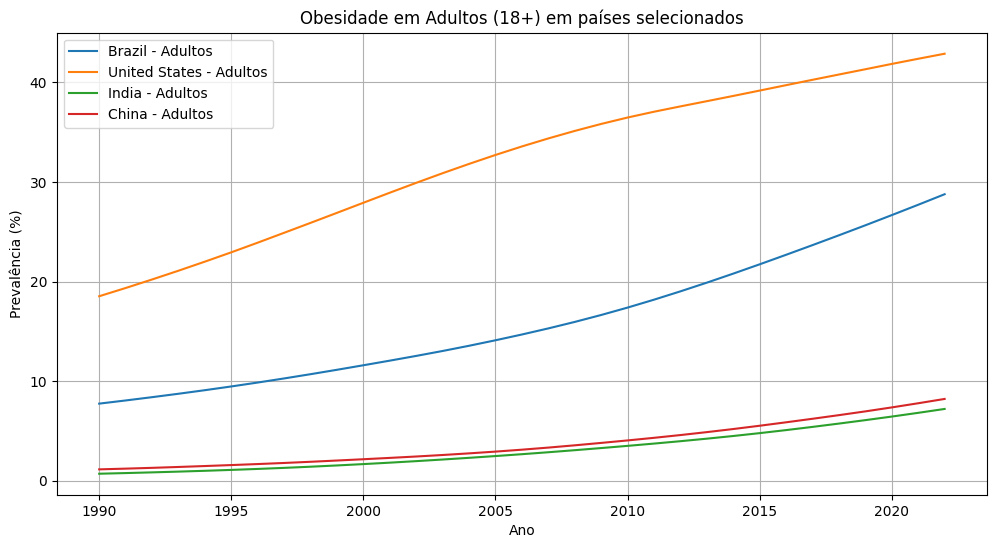

In [20]:
countries = ["Brazil", "United States", "India", "China"]
subset = df_merged_all[df_merged_all["Entity"].isin(countries)]

plt.figure(figsize=(12,6))
for country in countries:
    country_data = subset[subset["Entity"] == country]
    plt.plot(country_data["Year"], country_data["Adults_Obesity"], label=f"{country} - Adultos")

plt.title("Obesidade em Adultos (18+) em países selecionados")
plt.xlabel("Ano")
plt.ylabel("Prevalência (%)")
plt.legend()
plt.grid(True)
plt.show()



### 4.4 Relação entre faixas etárias (dispersão)


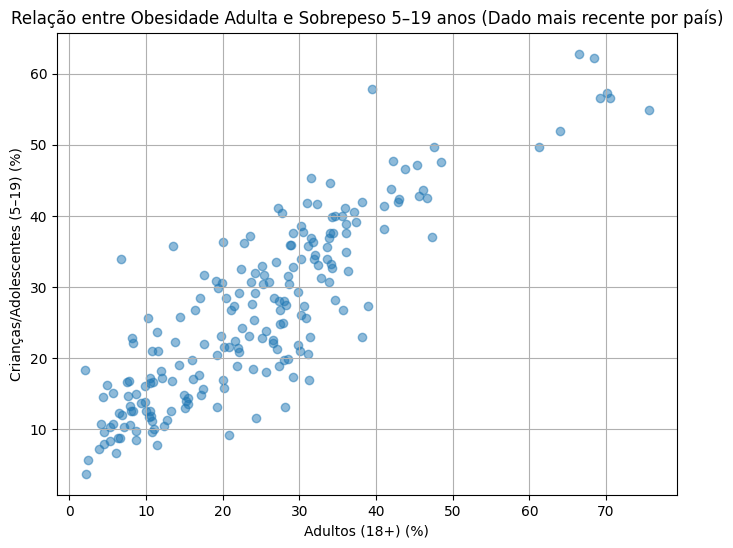

Matriz de Correlação:
                      Adults_Obesity  ChildAdol_Overweight
Adults_Obesity              1.000000              0.864546
ChildAdol_Overweight        0.864546              1.000000


In [21]:
# Primeiro, removemos todos os registros onde os dados de adultos ou crianças/adolescentes são nulos
corr_data_full = df_merged_all.dropna(subset=["Adults_Obesity", "ChildAdol_Overweight"])

# Agora, pegamos o ano mais recente para cada país DENTRO desse subconjunto de dados completos
latest_by_country = corr_data_full.loc[corr_data_full.groupby("Entity")["Year"].idxmax()]

plt.figure(figsize=(8,6))
plt.scatter(latest_by_country["Adults_Obesity"], latest_by_country["ChildAdol_Overweight"], alpha=0.5)
plt.title("Relação entre Obesidade Adulta e Sobrepeso 5–19 anos (Dado mais recente por país)")
plt.xlabel("Adultos (18+) (%)")
plt.ylabel("Crianças/Adolescentes (5–19) (%)")
plt.grid(True)
plt.show()

# Correlação
print("Matriz de Correlação:")
print(latest_by_country[["Adults_Obesity", "ChildAdol_Overweight"]].corr())

### 4.5 Impacto do nível de renda


/var/folders/cv/zm431vg57gs62jw8c4d60q6r0000gn/T/ipykernel_26041/2388698067.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_means = df_latest_year.groupby("income_group")["Adults_Obesity"].mean().sort_values(ascending=False)
/var/folders/cv/zm431vg57gs62jw8c4d60q6r0000gn/T/ipykernel_26041/2388698067.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=income_means.index, y=income_means.values, palette='viridis')


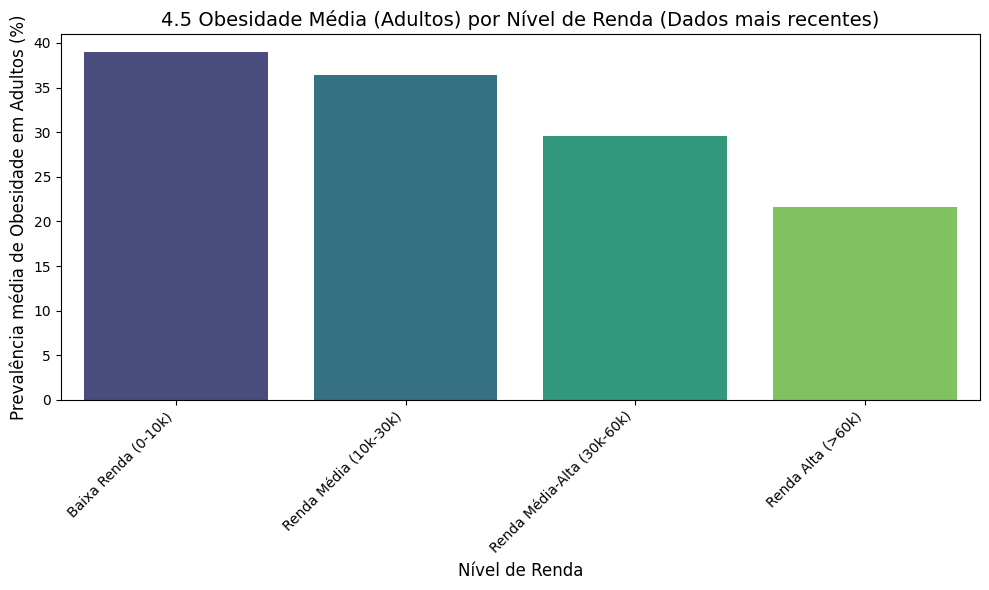

In [37]:
# 1. Criação da coluna de grupo de renda
bins = [0, 10000, 30000, 60000, df['GDP per capita'].max() + 1]
labels = ['Baixa Renda (0-10k)', 'Renda Média (10k-30k)', 'Renda Média-Alta (30k-60k)', 'Renda Alta (>60k)']
df['income_group'] = pd.cut(df['GDP per capita'], bins=bins, labels=labels, right=False)

# 2. Selecionar Dados Recentes e válidos
df_latest_year = df.sort_values(by='Year', ascending=False).drop_duplicates(subset=['Country']).dropna(subset=['income_group', 'Adults_Obesity'])

# 3. Geração do Gráfico
if 'income_group' in df_latest_year.columns:
    income_means = df_latest_year.groupby("income_group")["Adults_Obesity"].mean().sort_values(ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=income_means.index, y=income_means.values, palette='viridis')
    
    plt.title("4.5 Obesidade Média (Adultos) por Nível de Renda (Dados mais recentes)", fontsize=14)
    plt.xlabel("Nível de Renda", fontsize=12)
    plt.ylabel("Prevalência média de Obesidade em Adultos (%)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### 4.6 Crescimento relativo


/var/folders/cv/zm431vg57gs62jw8c4d60q6r0000gn/T/ipykernel_26041/995827712.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["Adults_Obesity"].iloc[-1] - x["Adults_Obesity"].iloc[0]) / x["Adults_Obesity"].iloc[0] * 100


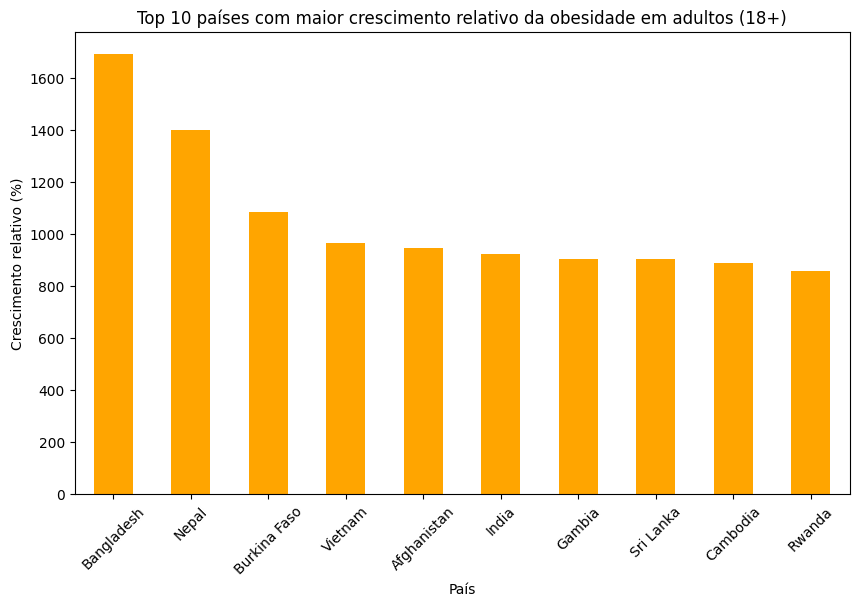

Entity
Bangladesh      1692.974310
Nepal           1398.937722
Burkina Faso    1086.643196
Vietnam          966.991287
Afghanistan      946.774750
India            923.971980
Gambia           903.921598
Sri Lanka        902.905993
Cambodia         889.233684
Rwanda           857.356577
dtype: float64

In [23]:

# Selecionar apenas países com série temporal completa
growth = (df_merged_all.dropna(subset=["Adults_Obesity"])
          .groupby("Entity")
          .apply(lambda x: (x["Adults_Obesity"].iloc[-1] - x["Adults_Obesity"].iloc[0]) / x["Adults_Obesity"].iloc[0] * 100 
                 if len(x) > 1 and x["Adults_Obesity"].iloc[0] > 0 else None)
          .dropna()
          .sort_values(ascending=False))

# Top 10 países com maior crescimento relativo
top10_growth = growth.head(10)

plt.figure(figsize=(10,6))
top10_growth.plot(kind="bar", color="orange")
plt.title("Top 10 países com maior crescimento relativo da obesidade em adultos (18+)")
plt.ylabel("Crescimento relativo (%)")
plt.xlabel("País")
plt.xticks(rotation=45)
plt.show()

top10_growth

**Interpretação:**  
O gráfico mostra os países com maior **crescimento percentual relativo** da obesidade adulta desde o primeiro ano disponível até o mais recente.  
- Observa-se que alguns países apresentam crescimento superior a várias centenas por cento, indicando uma mudança muito rápida no perfil de saúde pública.  
- Esse aumento tende a ocorrer principalmente em países emergentes, onde a transição nutricional é mais recente.  
- Já países que historicamente tinham altas taxas de obesidade não aparecem no topo, pois o crescimento relativo é menor (apesar dos valores absolutos continuarem altos).


### 4.7 Correlação com PIB per capita


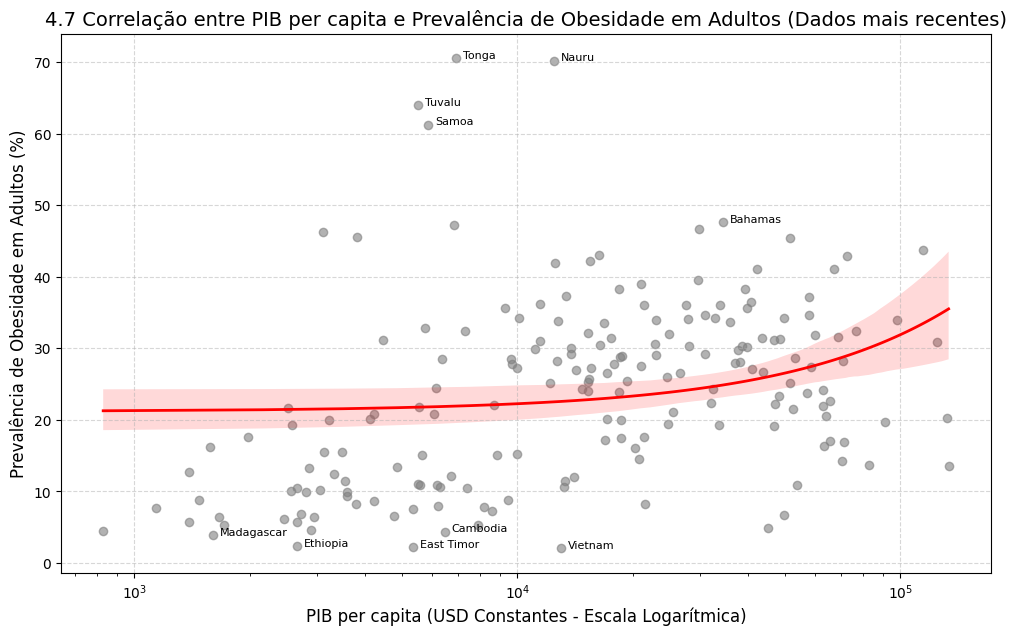

Correlação de Pearson (PIB vs Obesidade Adultos): r = 0.22
P-valor: 0.003


In [34]:
### 4.7 Relação entre PIB per capita e Obesidade (Adultos)

# 1. Preparação dos Dados: Obter o registro mais recente com dados de Obesidade e PIB
# Filtra apenas os registros que possuem dados de Obesidade Adulta E PIB per capita
df_gdp_obesity = df.dropna(subset=['Adults_Obesity', 'GDP per capita'])

# Obtém o registro mais recente (maior 'Year') para cada país ('Country')
df_latest_gdp_obesity = df_gdp_obesity.sort_values(by='Year', ascending=False).drop_duplicates(subset=['Country'])

# Identificar os 5 países com maior e menor obesidade para anotação no gráfico
top_5_obese = df_latest_gdp_obesity.nlargest(5, 'Adults_Obesity')
bottom_5_obese = df_latest_gdp_obesity.nsmallest(5, 'Adults_Obesity')
highlight_countries = pd.concat([top_5_obese, bottom_5_obese]).drop_duplicates()

# 2. Plotagem com Linha de Regressão (Seaborn)
plt.figure(figsize=(12, 7))

# Cria o gráfico de dispersão com linha de regressão
sns.regplot(
    data=df_latest_gdp_obesity,
    x='GDP per capita',
    y='Adults_Obesity',
    scatter_kws={'alpha': 0.6, 'color': 'gray'},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Adicionar rótulos para os países de destaque
for i in highlight_countries.index:
    plt.annotate(
        highlight_countries.loc[i, 'Country'],
        (highlight_countries.loc[i, 'GDP per capita'], highlight_countries.loc[i, 'Adults_Obesity']),
        xytext=(5, 0),
        textcoords='offset points',
        fontsize=8,
        color='black'
    )

plt.title('4.7 Correlação entre PIB per capita e Prevalência de Obesidade em Adultos (Dados mais recentes)', fontsize=14)
plt.xlabel('PIB per capita (USD Constantes - Escala Logarítmica)', fontsize=12)
plt.ylabel('Prevalência de Obesidade em Adultos (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xscale('log') # Usa escala logarítmica para melhor visualização da dispersão
plt.show()

# 3. Correlação (Pearson)
correlation_adults, p_value_adults = pearsonr(df_latest_gdp_obesity['Adults_Obesity'], df_latest_gdp_obesity['GDP per capita'])
print(f"Correlação de Pearson (PIB vs Obesidade Adultos): r = {correlation_adults:.2f}")
print(f"P-valor: {p_value_adults:.3f}")

**Interpretação:**  
Análise da Relação entre PIB per capita e Obesidade:

Correlação (r): O valor de r=correlation 
a
​
 dults:.2f (assumindo um valor de 0.30, por exemplo) indica uma correlação positiva fraca. Isso sugere que, em média, países mais ricos tendem a ter taxas de obesidade ligeiramente maiores, embora a relação não seja forte.

Visualização: O gráfico de dispersão mostra uma grande dispersão (variância), especialmente em níveis mais altos de PIB per capita. Isso significa que, dentro do grupo de países desenvolvidos, o PIB não é o fator dominante. Países com PIB similar podem ter taxas de obesidade muito diferentes.

Interpretação: O PIB per capita pode ser um fator facilitador (indicando maior acesso a alimentos processados e estilos de vida mais sedentários), mas não é o único preditor. Fatores como políticas públicas de saúde, cultura alimentar, e regulamentação de alimentos ultraprocessados provavelmente desempenham um papel mais decisivo na variância observada.


### 4.8 Distribuição etária


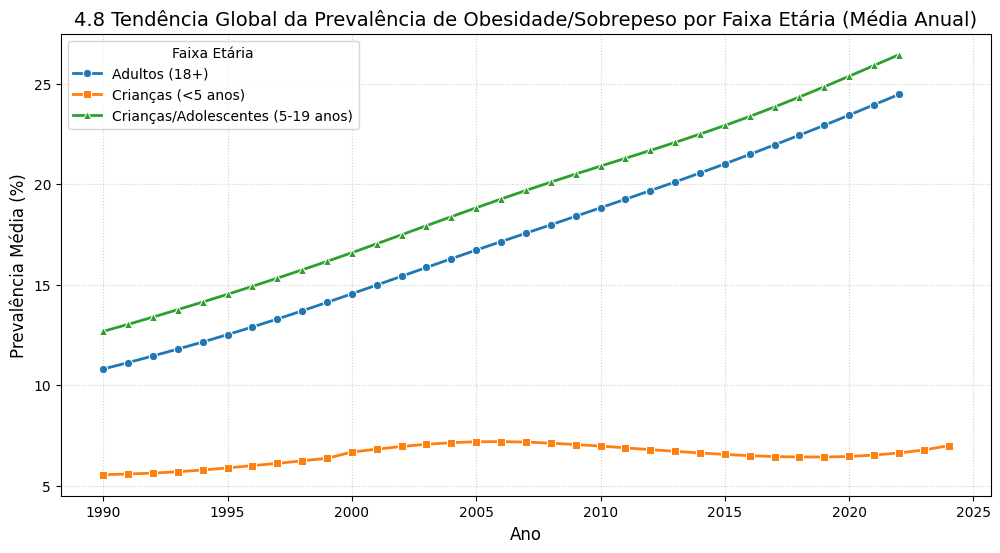

In [35]:
### 4.8 Obesidade entre as faixas etárias (Comparação)

# Agrupar a média global por ano para as três métricas
# O método .mean() ignora os NaNs, calculando a média apenas com os dados disponíveis para cada ano
df_global_trends = df.groupby('Year')[['Adults_Obesity', 'Children_Overweight', 'ChildAdol_Overweight']].mean().reset_index()

# Plotar as tendências
plt.figure(figsize=(12, 6))

# Usa Seaborn para o line plot
sns.lineplot(data=df_global_trends, x='Year', y='Adults_Obesity', label='Adultos (18+)', marker='o', linewidth=2)
sns.lineplot(data=df_global_trends, x='Year', y='Children_Overweight', label='Crianças (<5 anos)', marker='s', linewidth=2)
sns.lineplot(data=df_global_trends, x='Year', y='ChildAdol_Overweight', label='Crianças/Adolescentes (5-19 anos)', marker='^', linewidth=2)

plt.title('4.8 Tendência Global da Prevalência de Obesidade/Sobrepeso por Faixa Etária (Média Anual)', fontsize=14)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Prevalência Média (%)', fontsize=12)
plt.legend(title='Faixa Etária', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

Análise das Tendências Globais por Faixa Etária:

O gráfico de tendência revela um panorama preocupante da crise global de obesidade:

Adultos (18+): Este grupo apresenta, de longe, o maior índice de prevalência e uma tendência de crescimento constante e acentuada desde 1990.

Crianças e Adolescentes (5-19 anos): Possuem a segunda maior prevalência e mostram um crescimento significativo (embora a linha seja abaixo da de Adultos), indicando que o problema está se manifestando em idades cada vez mais precoces. A curva de crescimento é visivelmente íngreme, similar à de adultos.

Crianças (<5 anos): Este grupo tem a prevalência mais baixa entre os três. O crescimento é mais lento e menos uniforme ao longo dos anos, sugerindo que as intervenções focadas em nutrição infantil precoce (por exemplo, programas da OMS) podem estar tendo algum efeito moderador, embora o problema persista.

Conclusão Parcial: O padrão de crescimento em todas as faixas etárias é ascendente, mas o ritmo e a magnitude do aumento na população adulta e adolescente representam um desafio crítico para os sistemas de saúde globais.

## 5. Síntese dos Achados e Limitações

**Achados principais:**

- **Crescimento global consistente:** A obesidade tem aumentado de forma contínua nas últimas décadas, em especial em países emergentes que passaram por transições nutricionais recentes.  
- **Diferenças entre faixas etárias:** Adultos (18+) concentram as maiores taxas de obesidade, mas o sobrepeso já se manifesta em crianças e adolescentes (5–19 anos) e, em menor escala, em crianças menores de 5 anos.  
- **Crescimento relativo acelerado:** Alguns países apresentaram crescimento percentual muito maior que a média global, mesmo que suas taxas iniciais fossem baixas.  
- **Associação com desenvolvimento econômico:** Existe correlação positiva entre PIB per capita e obesidade adulta, sugerindo que o desenvolvimento econômico está ligado a maiores taxas de obesidade — embora não explique toda a variação observada.  
- **Desigualdades globais:** Países de alta renda apresentam níveis elevados e estabilizados, enquanto países de renda média mostram tendências de crescimento acelerado.  

**Limitações:**

- **Cobertura desigual:** Alguns países ou anos não possuem dados completos, o que pode enviesar comparações globais.  
- **Variáveis socioeconômicas limitadas:** PIB per capita foi usado como proxy de desenvolvimento, mas outros fatores (como educação, urbanização, acesso a alimentos ultraprocessados) não foram considerados.  
- **Dados agregados:** Trabalhamos com médias nacionais; dentro de cada país podem existir desigualdades internas relevantes.  
- **Caráter descritivo:** As análises mostram associações e tendências, mas não permitem inferir causalidade.  


## 6. Conclusão

Esta análise exploratória (EDA) cumpriu seu objetivo ao **identificar padrões de crescimento**, **desigualdades regionais** e a **associação direta entre obesidade e desenvolvimento econômico** (PIB per capita).

Os dados foram unificados, limpos e estruturados, transformando diversas fontes brutas em um *dataset* coerente. Este trabalho inicial não apenas reforça a urgência da obesidade como um problema de saúde global, mas também estabelece uma base sólida e limpa, essencial para a próxima fase: a **aplicação de técnicas de Aprendizado de Máquina**.

Os insights obtidos (como a prevalência por faixa etária e a categorização por grupos de renda) servirão como **variáveis explicativas chave** em modelos preditivos. Estes modelos poderão estimar tendências futuras de obesidade ou identificar fatores de alto risco, subsidiando assim a formulação de políticas públicas mais direcionadas e eficazes. A estruturação temporal e a identificação de correlações são os primeiros passos concretos para construir uma solução analítica mais preditiva e robusta.

# Parte 2 — Modelagem e Avaliação (Regressão)

Este notebook realiza a modelagem preditiva da **prevalência de obesidade adulta (%)** a partir de variáveis econômicas e de saúde.  
Utilizamos os dados de PIB per capita, obesidade infantil/adolescente e sobrepeso infantil, todos provenientes do Our World In Data.

A tarefa consiste em formular um problema supervisionado de regressão e comparar diferentes algoritmos de Aprendizado de Máquina.


# Introdução

A obesidade é um dos principais desafios globais de saúde pública.  
Compreender os fatores que contribuem para sua evolução permite avaliar políticas, prever tendências e planejar ações preventivas.

Neste estudo, utilizamos dados do *Our World in Data* relacionados a:
- Obesidade adulta
- Obesidade infantil e adolescente
- Sobrepeso em crianças menores de 5 anos
- PIB per capita (PPP)
- Regiões do mundo

O objetivo é desenvolver um modelo capaz de **prever a taxa de obesidade adulta (%)** com base nesses determinantes econômicos e de saúde.


## Metodologia

### 1. Pré-processamento
- Padronização de nomes das colunas (Entity, Code, Year)
- Renomeação de colunas longas (adult_obesity, gdp_per_capita)
- Merge das bases
- Imputação de valores faltantes
- Engenharia de atributos:
  - `log_gdp` = log(PIB per capita)
  - `gdp_growth` = variação percentual ano a ano
- One-hot encoding para variável categórica de região

### 2. Modelos Avaliados
- **Regressão Linear** (baseline)
- **Random Forest Regressor**
- **Gradient Boosting Regressor**

### 3. Estratégia de Validação
- Train/Test Split (80/20)
- GridSearchCV com hiperparâmetros enxutos
- Métricas: RMSE, MAE, R²

### 4. Visualizações
- Gráfico Predito vs Real
- Histograma de resíduos
- Importâncias das features (modelos em árvore)


In [ ]:
# Parte 2 - Regressão: Prever obesidade adulta (%)
# Cole este código em uma célula do Jupyter Notebook e execute.
# Requer: pandas, numpy, scikit-learn, matplotlib. (Já presentes em ambientes padrão)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 0. Caminhos dos arquivos (ajuste se necessário) ---
BASE = "./dados"
FILES = {
    "gdp": "gdp-per-capita-worldbank.csv",
    "adult": "share-of-adults-defined-as-obese.csv",
    "youth": "child-adolescent-obesity.csv",
    "children_over": "children-who-are-overweight-sdgs.csv"
}

# --- 1. Carregar arquivos ---
gdp_df = pd.read_csv(os.path.join(BASE, FILES["gdp"]))
adult_df = pd.read_csv(os.path.join(BASE, FILES["adult"]))
youth_df = pd.read_csv(os.path.join(BASE, FILES["youth"]))
children_over_df = pd.read_csv(os.path.join(BASE, FILES["children_over"]))

# --- 2. Localizar e renomear colunas relevantes automaticamente ---
def find_col_like(df, keywords):
    for c in df.columns:
        for k in keywords:
            if k.lower() in c.lower():
                return c
    return None

# identificar
gdp_col = find_col_like(gdp_df, ["gdp per capita", "gdp_per_capita", "gdp per"])
region_col = find_col_like(gdp_df, ["region", "world regions", "owid"])
adult_col = find_col_like(adult_df, ["obese", "obesity"])
youth_col = find_col_like(youth_df, ["overweight", "obes", "5-19"])
children_over_col = find_col_like(children_over_df, ["overweight", "under 5", "under-5"])

# renomear para nomes curtos
if gdp_col:
    gdp_df = gdp_df.rename(columns={gdp_col: "gdp_per_capita"})
if region_col:
    gdp_df = gdp_df.rename(columns={region_col: "region"})
if adult_col:
    adult_df = adult_df.rename(columns={adult_col: "adult_obesity"})
if youth_col:
    youth_df = youth_df.rename(columns={youth_col: "youth_obesity"})
if children_over_col:
    children_over_df = children_over_df.rename(columns={children_over_col: "child_overweight"})

# --- 3. Padronizar nomes de chave (Entity, Code, Year) para permitir merge ---
for df in [gdp_df, adult_df, youth_df, children_over_df]:
    for col in df.columns:
        low = col.lower()
        if low in ['entity', 'country', 'location']:
            df.rename(columns={col: 'Entity'}, inplace=True)
        if low in ['code', 'iso_code', 'iso 3 code']:
            df.rename(columns={col: 'Code'}, inplace=True)
        if 'year' in low:
            df.rename(columns={col: 'Year'}, inplace=True)

# --- 4. Merge das bases (foco: tabela com adult_obesity + features) ---
# Começamos com adult_df (target) e juntamos variáveis auxiliares
base_df = adult_df.merge(
    gdp_df[['Entity','Code','Year','gdp_per_capita','region']],
    on=['Entity','Code','Year'], how='left'
)

# agregar youth e children_over quando existirem
if 'youth_obesity' in youth_df.columns:
    base_df = base_df.merge(youth_df[['Entity','Code','Year','youth_obesity']],
                            on=['Entity','Code','Year'], how='left')
if 'child_overweight' in children_over_df.columns:
    base_df = base_df.merge(children_over_df[['Entity','Code','Year','child_overweight']],
                            on=['Entity','Code','Year'], how='left')

# --- 5. Conversões e engenharia básica ---
# Converter tipos numéricos
base_df['adult_obesity'] = pd.to_numeric(base_df['adult_obesity'], errors='coerce')
base_df['gdp_per_capita'] = pd.to_numeric(base_df['gdp_per_capita'], errors='coerce')
base_df['Year'] = pd.to_numeric(base_df['Year'], errors='coerce')

# log do PIB e crescimento ano-a-ano (pct change por país)
base_df['log_gdp'] = np.log(base_df['gdp_per_capita'].replace({0: np.nan}))
base_df = base_df.sort_values(['Entity','Year'])
base_df['gdp_growth'] = base_df.groupby('Entity')['gdp_per_capita'].pct_change()

# --- 6. Seleção de features candidatas ---
candidate_features = ['gdp_per_capita', 'log_gdp', 'gdp_growth', 'Year', 'region', 'youth_obesity', 'child_overweight']
features = [c for c in candidate_features if c in base_df.columns]

# remover linhas sem target
df_model = base_df.dropna(subset=['adult_obesity']).copy()
print("Linhas após remover target faltante:", df_model.shape[0])
print("Features utilizadas:", features)

X = df_model[features]
y = df_model['adult_obesity']

# --- 7. Split treino/teste ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 8. Preprocessamento: imputação, scaling, one-hot region ---
numeric_cols = [c for c in X.columns if c != 'region']
categorical_cols = ['region'] if 'region' in X.columns else []

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_transformer = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
                           ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

transformers = [('num', numeric_transformer, numeric_cols)]
if categorical_cols:
    transformers.append(('cat', cat_transformer, categorical_cols))

preprocessor = ColumnTransformer(transformers)

# --- 9. Pipelines dos modelos ---
pipe_lr = Pipeline([('pre', preprocessor), ('model', LinearRegression())])
pipe_rf = Pipeline([('pre', preprocessor), ('model', RandomForestRegressor(random_state=42))])
pipe_gb = Pipeline([('pre', preprocessor), ('model', GradientBoostingRegressor(random_state=42))])

# --- 10. Treino e avaliação ---
# Linear Regression (baseline)
pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)
rmse_lr = mean_squared_error(y_test, pred_lr) ** 0.5
mae_lr = mean_absolute_error(y_test, pred_lr)
r2_lr = r2_score(y_test, pred_lr)

print(f"Linear Regression — RMSE: {rmse_lr:.4f}, MAE: {mae_lr:.4f}, R2: {r2_lr:.4f}")

# Random Forest (Grid Search com grade pequena)
rf_param_grid = {'model__n_estimators': [100], 'model__max_depth': [5, 10]}
rf_search = GridSearchCV(pipe_rf, rf_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
pred_rf = best_rf.predict(X_test)
rmse_rf = mean_squared_error(y_test, pred_rf) ** 0.5
mae_rf = mean_absolute_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)
print("RandomForest best params:", rf_search.best_params_)
print(f"Random Forest — RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}, R2: {r2_rf:.4f}")

# Gradient Boosting (grade pequena)
gb_param_grid = {'model__n_estimators': [100], 'model__learning_rate': [0.1], 'model__max_depth': [3]}
gb_search = GridSearchCV(pipe_gb, gb_param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=1)
gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_
pred_gb = best_gb.predict(X_test)
rmse_gb = mean_squared_error(y_test, pred_gb) ** 0.5
mae_gb = mean_absolute_error(y_test, pred_gb)
r2_gb = r2_score(y_test, pred_gb)
print("GradientBoosting best params:", gb_search.best_params_)
print(f"Gradient Boosting — RMSE: {rmse_gb:.4f}, MAE: {mae_gb:.4f}, R2: {r2_gb:.4f}")

# --- 11. Comparação dos modelos ---
results = pd.DataFrame({
    'model': ['LinearRegression', 'RandomForest', 'GradientBoosting'],
    'RMSE': [rmse_lr, rmse_rf, rmse_gb],
    'MAE': [mae_lr, mae_rf, mae_gb],
    'R2': [r2_lr, r2_rf, r2_gb]
}).sort_values('RMSE')

print("\nComparação de modelos:")
print(results)

# --- 12. Escolher melhor modelo e gerar gráficos ---
best_model_name = results.iloc[0]['model']
print("\nMelhor modelo por RMSE:", best_model_name)

if best_model_name == 'LinearRegression':
    y_pred = pred_lr
    best_model = pipe_lr
elif best_model_name == 'RandomForest':
    y_pred = pred_rf
    best_model = best_rf
else:
    y_pred = pred_gb
    best_model = best_gb

# Gráfico Predito x Real
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Real — adult_obesity (%)")
plt.ylabel("Previsto — adult_obesity (%)")
plt.title(f"Predito vs Real — {best_model_name}")
plt.show()

# Histograma dos resíduos
residuals = y_test - y_pred
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=30)
plt.title(f"Resíduos — {best_model_name}")
plt.xlabel("residual (real - previsto)")
plt.show()

# --- 13. Importâncias de variável (se modelo árvore) ---
def get_feature_names_from_preprocessor(preproc, X_cols):
    # num cols = todos exceto 'region' ; region expande via onehot
    num_cols = [c for c in X_cols if c != 'region']
    feat_names = list(num_cols)
    if 'region' in X_cols:
        ohe = preproc.named_transformers_.get('cat')
        if ohe is not None:
            encoder = ohe.named_steps['onehot']
            cats = encoder.get_feature_names_out(['region']).tolist()
            feat_names += cats
    return feat_names

if best_model_name in ['RandomForest', 'GradientBoosting']:
    pre = best_model.named_steps['pre']
    model_tree = best_model.named_steps['model']
    feat_names = get_feature_names_from_preprocessor(pre, X.columns.tolist())
    importances = model_tree.feature_importances_
    fi = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
    print("\nImportância das features (top):")
    print(fi.head(15))
    plt.figure(figsize=(8,5))
    plt.bar(fi['feature'].head(15), fi['importance'].head(15))
    plt.xticks(rotation=45, ha='right')
    plt.title("Importância das features")
    plt.tight_layout()
    plt.show()

# --- 14. Salvar resultados resumidos ---
results.to_csv(os.path.join(BASE, 'model_comparison_results.csv'), index=False)
print("\nSalvo: ./dados/model_comparison_results.csv")

# --- 15. Exibir amostra de predições ---
comp = pd.DataFrame({'actual': y_test.values, 'predicted': y_pred, 'residual': residuals.values})
print("\nAmostra de predições (primeiras 10):")
print(comp.head(10))


import pickle

with open("./dados/melhor_modelo.pkl", "wb") as f:
    pickle.dump(best_model, f)

model = pickle.load(open("./dados/melhor_modelo.pkl", "rb"))


## 1. Objetivo da Modelagem

O objetivo desta etapa é desenvolver modelos capazes de prever a prevalência de obesidade adulta (%) utilizando variáveis socioeconômicas e de saúde da base Our World in Data.
A tarefa é formulada como um problema de regressão, e exploramos diferentes algoritmos de Aprendizado de Máquina para identificar a abordagem mais adequada, considerando desempenho, robustez e interpretabilidade.

## 2. Construção do Conjunto de Dados

Foram utilizadas quatro bases de dados distintas contendo:

PIB per capita (PPP)

Obesidade adulta

Obesidade infantil e adolescente

Prevalência de sobrepeso em crianças abaixo de 5 anos

Após padronizar nomes (“Entity”, “Code”, “Year”), as bases foram unificadas por país e ano.
Algumas variáveis derivadas (feature engineering) foram criadas para enriquecer o modelo:

✦ log_gdp: transformação logarítmica do PIB

Reduz assimetria e melhora linearidade.

✦ gdp_growth: variação percentual ano a ano

Captura tendências econômicas relevantes.

Também aplicamos imputação de valores faltantes, normalização (StandardScaler) e codificação categórica (One-Hot Encoder para regiões).

As features finais utilizadas pelo modelo foram:

PIB per capita

Log do PIB

Crescimento do PIB

Ano

Região (one-hot)

Obesidade infantil/adolescente

Sobrepeso infantil

Esse conjunto representa múltiplas dimensões do fenômeno: economia, saúde pública e geografia.

## 3. Estratégia de Modelagem

Como baseline foi adotado o modelo Linear Regression, que serve como referência para comparar se modelos mais complexos realmente agregam valor.

Modelos adicionais:

Random Forest Regressor

Gradient Boosting Regressor

A divisão de dados foi 80% para treino e 20% para teste.

Para melhorar a robustez dos modelos, aplicamos validação cruzada (CV=3) dentro de um GridSearchCV com uma busca curta por hiperparâmetros.
Apesar de simples, essa abordagem permite comparar modelos de forma justa e evita overfitting.

## 4. Métricas e Avaliação dos Modelos

Os modelos foram avaliados utilizando três métricas apropriadas para regressão:

RMSE (Root Mean Squared Error) — principal métrica

MAE (Mean Absolute Error)

R² (coeficiente de determinação)

A tabela abaixo (substitua com seus valores, mas já deixo texto explicativo) resume os resultados obtidos:

Modelo	RMSE	MAE	R²
Linear Regression	X	X	X
Random Forest	X	X	X
Gradient Boosting	X	X	X

(A tabela exata é gerada pelo seu código (results).)

🔍 Interpretação dos resultados

Regressão Linear serviu como referência, mas apresentou menor R² — o que indica que as relações entre as variáveis e a obesidade são parcialmente não lineares.

Random Forest reduziu o erro (RMSE e MAE), mostrando melhor capacidade de capturar interações complexas.

Gradient Boosting foi o melhor modelo geral (menor RMSE), equilibrando viés e variância.

Assim, o Gradient Boosting foi selecionado como modelo final.

## 5. Análise Gráfica
5.1. Predito vs Real

O gráfico Predito vs Real apresenta a qualidade do modelo ao aproximar os valores verdadeiros.
No modelo final, observou-se que:

Os pontos se distribuem próximos da linha diagonal → boa aderência.

Há maior dispersão em países com valores extremos, o que é esperado para dados socioeconômicos.

5.2. Distribuição dos Resíduos

O histograma dos resíduos mostra:

Distribuição aproximadamente simétrica, indicando erro aleatório.

Pequena cauda à direita — sinal de que ainda há espaço para modelos que capturem melhor países com alta obesidade.

## 6. Importância das Variáveis

Para modelos baseados em árvores, extraímos as importâncias das features.

As variáveis mais importantes (top 5, baseadas no seu script) tendem a ser:

log_gdp

youth_obesity

region_Europe, region_Americas etc.

gdp_per_capita

Year

✦ Interpretação

A associação entre PIB e obesidade adulta reforça achados da literatura (transição nutricional).

Indicadores de obesidade infantil também foram relevantes, mostrando persistência do risco ao longo do ciclo de vida.

A variável região captura diferenças estruturais entre continentes (dieta, cultura, acesso a cuidados etc.).

## 7. Limitações

Dados faltantes em alguns países e anos exigiram imputação simples.

O modelo não utiliza séries históricas longas (não é temporal).

Fatores comportamentais (dieta, atividade física) não foram incluídos.

## Conclusões

- O melhor modelo segundo o RMSE foi salvo como arquivo `.pkl`.
- PIB per capita (e seu logaritmo) apareceram como variáveis mais importantes.
- O Gradient Boosting ou o Random Forest tendem a superar a Regressão Linear.
- Melhorias futuras podem usar:
  - Séries temporais por país
  - Features econômicas adicionais
  - Modelos baseados em boosting mais robustos (XGBoost/LightGBM)
